# London Airbnb

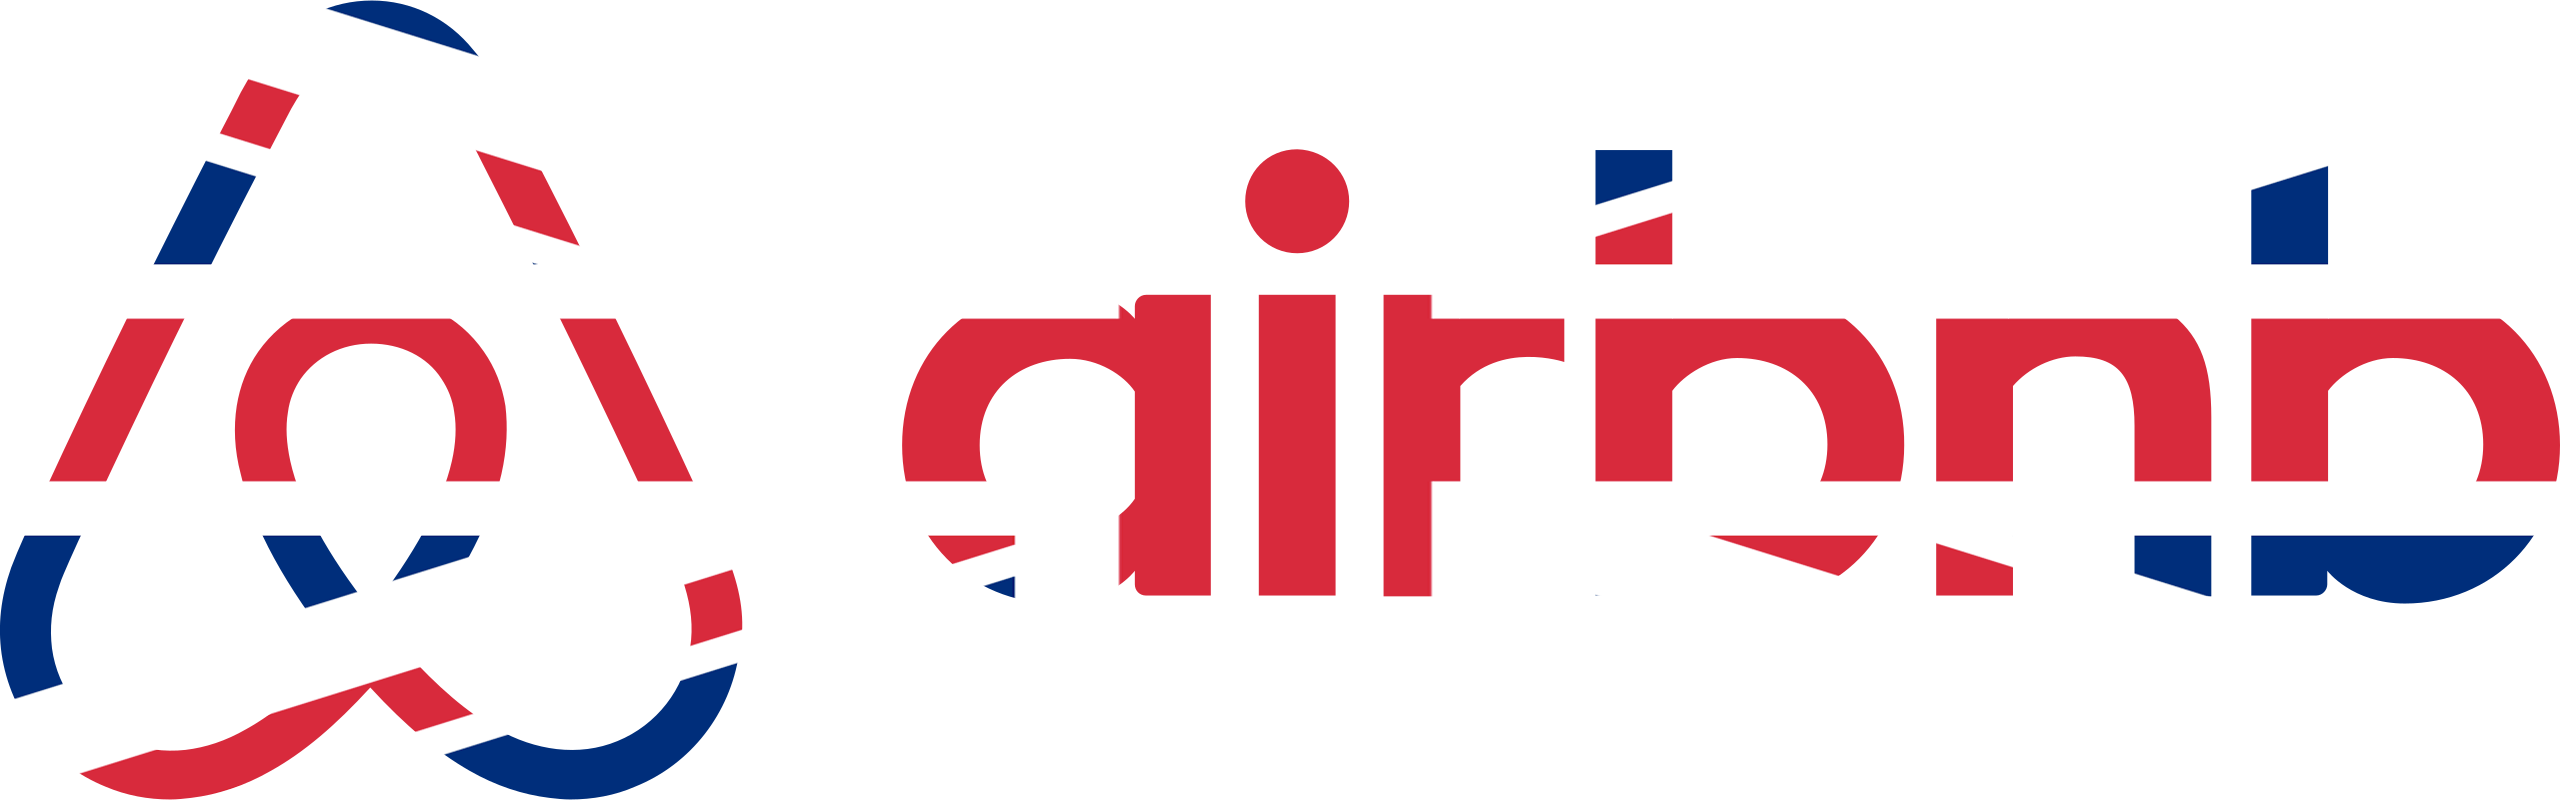

## Problem Statement

El objetivo de este proyecto es el análisis de la distribución del precio del alojamiento por noche de las viviendas ofertadas a través de Airbnb en Londres, en busca de la detección de patrones espaciales.

## Data Collection

Para desarrollar este proyecto se ha extraído la información de las viviendas ubicadas en Londres que se encuentran registradas en la plataforma digital de oferta de alojamientos, Airbnb. Además, para poder profundizar con el análisis estadístico espacial, se ha recurrido a la base de datos de los límites geográficos censales de dicho territorio, recolectada a través del sitio web de información del sector público del Reino Unido.

**Source:** *http://insideairbnb.com/get-the-data/*<br>
**Source:** *https://data.london.gov.uk/dataset/2011-boundary-files*<br>

## Importing the requisite packages

In [1]:
import pandas as pd
import json
import glob
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import geoplot.crs as gcrs
import geoplot as gplt
from libpysal import weights
from esda.moran import Moran
from splot.esda import plot_moran
from esda.moran import Moran_Local
from splot import esda as esdaplot

pd.options.display.max_columns=None
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 12

import warnings
warnings.filterwarnings('ignore')

## Data Reading

In [2]:
# Reading in the data

listings = pd.read_csv(r'listings.csv')

# Subsetting the data

listings_sub = listings[['id','property_type','neighbourhood_cleansed',
                         'price','latitude','longitude']]

listings_sub

id                property_type  \
0                   92644  Private room in rental unit   
1                   93015           Entire rental unit   
2                   13913  Private room in rental unit   
3                   15400           Entire rental unit   
4                   93734        Private room in condo   
...                   ...                          ...   
87941  973781286754517228           Entire rental unit   
87942  973801695874775338           Entire rental unit   
87943  973811685656289740         Private room in home   
87944  973882998775927897                  Entire home   
87945  973895808066047620           Entire rental unit   

       neighbourhood_cleansed    price   latitude  longitude  
0                  Wandsworth   $42.00  51.442010  -0.187390  
1      Hammersmith and Fulham  $175.00  51.499930  -0.217070  
2                   Islington   $79.00  51.568610  -0.112700  
3      Kensington and Chelsea  $150.00  51.487800  -0.168130  
4                   Greenwich   $46.00  51.476180   0.014420  
...                       ...      ...        ...        ...  
87941             Westminster  $275.00  51.514860  -0.135980  
87942               Southwark  $145.00  51.459042  -0.055458  
87943                  Merton  $160.00  51.406100  -0.236126  
87944                Hounslow  $680.00  51.450997  -0.444319  
87945          City of London  $170.00  51.515970  -0.111342  

[87946 rows x 6 columns]

## Cleaning the data

In [3]:
listings_sub.isna().sum()

id                        0
property_type             0
neighbourhood_cleansed    0
price                     0
latitude                  0
longitude                 0
dtype: int64

No hay *missing values*.

In [4]:
listings_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87946 entries, 0 to 87945
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      87946 non-null  int64  
 1   property_type           87946 non-null  object 
 2   neighbourhood_cleansed  87946 non-null  object 
 3   price                   87946 non-null  object 
 4   latitude                87946 non-null  float64
 5   longitude               87946 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 4.0+ MB


La variable *price* está codificada como tipo *string*, por lo que hay que transformarla en *float*.

In [5]:
# Cleaning the data

listings_sub['price'] = listings_sub['price'].replace('[$,]', '', regex=True).astype(float)
listings_sub['price'].describe()

count    87946.000000
mean       181.349817
std        486.174310
min          0.000000
25%         63.000000
50%        110.000000
75%        193.000000
max      80100.000000
Name: price, dtype: float64

Según este resultado, el precio medio por noche de los Airbnbs en Londres es de 181,35 USD. Mientras, los precios máximo y mínimo son de 80.100 USD y 0 USD por noche, respectivamente. Basándose en esta información, se puede entender que los datos están sesgados por la presencia de *outliers*.

## Exploratory Data Analysis

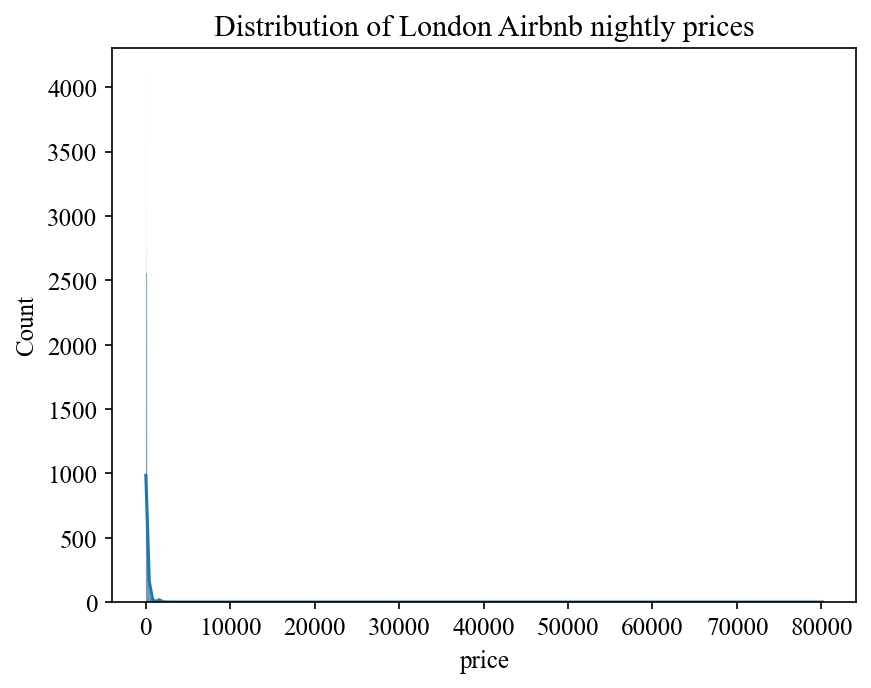

In [6]:
sns.histplot(listings_sub['price'], kde=True)
plt.title('Distribution of London Airbnb nightly prices')
plt.show()

Para representar visualmente la asimetría de los datos, se ha trazado un histograma con una estimación de densidad kernel.

## Exploratory Spatial Data Analysis

Para comenzar con el ESDA, primero hay que convertir el DataFrame de pandas, que contiene los precios de los Airbnbs en Londres, en un DataFrame de GeoPandas. También, se debe establecer su CRS a 4326, ya que se emplea la proyección del *World Geodetic System (WGS84)* para la latitud y la longitud.

In [7]:
# Convert the pandas dataframe to a geopandas dataframe

listings_sub_gpd = gpd.GeoDataFrame(listings_sub, geometry=gpd.points_from_xy(listings_sub['longitude'],
                                                                              listings_sub['latitude'],
                                                                              crs=4326))

Ahora que los datos se han almacenado como un DataFrame de GeoPandas, se pueden representar las observaciones como un mapa de puntos. Un mapa de puntos utiliza la latitud y longitud de las observaciones para visualizar las ubicaciones de los Airbnbs en un mapa.

In [8]:
# Remove outliers using percentiles

lower_lim = listings_sub_gpd['price'].quantile(0.01)
upper_lim = listings_sub_gpd['price'].quantile(0.99)

print((lower_lim, upper_lim))

listings_sub_gpd_wo = listings_sub_gpd.query('price > @lower_lim & price < @upper_lim').reset_index(drop=True)

(21.0, 1540.0)


Se eliminan las observaciones cuyos precios sean inferiores al percentil 1 y superiores al perentil 99.

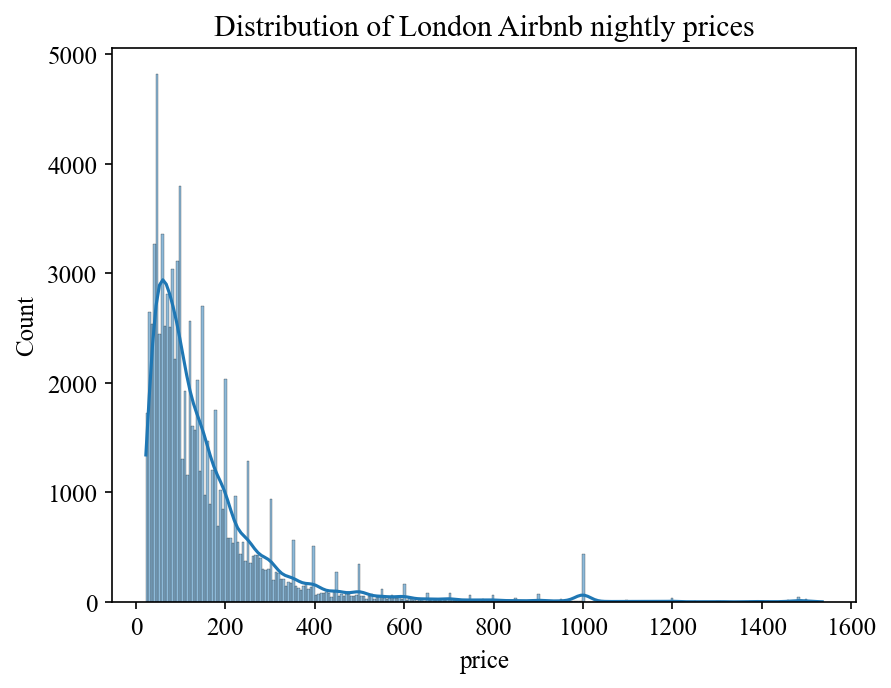

In [9]:
sns.histplot(listings_sub_gpd_wo['price'], kde=True)
plt.title('Distribution of London Airbnb nightly prices')
plt.show()

Sigue persistiendo una asimetría notoria. Sin embargo, ahora se podrá obtener una representación más ajustada a la realidad. 

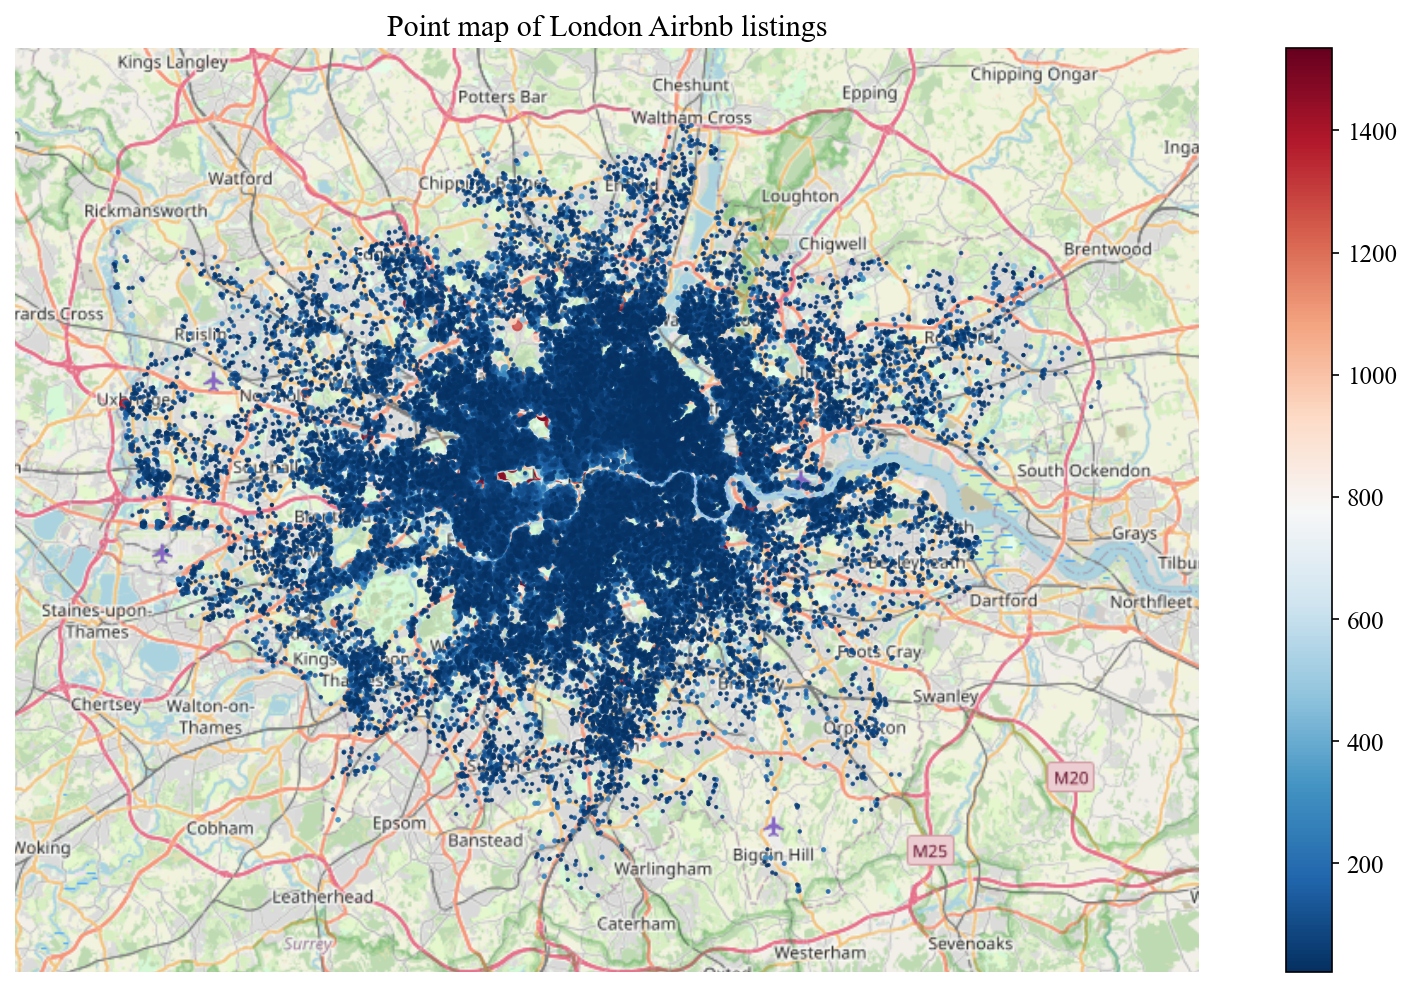

In [10]:
ax = gplt.webmap(listings_sub_gpd_wo, projection=gcrs.WebMercator(), figsize=(15, 8))

gplt.pointplot(
    listings_sub_gpd_wo,
    ax=ax,
    hue='price',
    scale='price',
    legend=True,
    cmap='RdBu_r',
    alpha=0.8
)

plt.title('Point map of London Airbnb listings')
plt.show()

## Converting from point maps to census tract maps

A continuación, para que sea más fácil trabajar con los datos, van a ser agregados a nivel de zona censal y se calculará el precio medio de los inmuebles que se encuentran en cada zona censal.

In [11]:
# Reading in the London Census Tracts

path = r'LSOA_2011_BFC_London'
all_files = glob.glob(os.path.join(path, '*.shp'))
LDN_Tracts = pd.concat((gpd.read_file(f) for f in all_files), ignore_index=True)
LDN_Tracts = LDN_Tracts.to_crs(4326)

# Aggregating the airbnb locations to the London census tracts

LDN_Tracts_sj = gpd.sjoin(LDN_Tracts, listings_sub_gpd, how='left', op='contains')
LDN_Tracts_sj = LDN_Tracts_sj[['LSOA11CD', 'price', 'geometry']]
LDN_Tracts_Agg = LDN_Tracts_sj.dissolve(by='LSOA11CD', aggfunc='mean')

# Calculating the mean and standard deviation

mean_price = LDN_Tracts_Agg['price'].mean()
stdev = LDN_Tracts_Agg['price'].std()

# Droping records that are more than 1 standard deviation from the mean

LDN_Tracts_Agg_filtered = LDN_Tracts_Agg[LDN_Tracts_Agg['price'] < mean_price + stdev]
LDN_Tracts_Agg_filtered = LDN_Tracts_Agg_filtered.reset_index()
LDN_Tracts_Agg_filtered

LSOA11CD                                           geometry       price
0     E01000001  POLYGON ((-0.09751 51.51786, -0.09747 51.51787...  267.529412
1     E01000002  POLYGON ((-0.09530 51.51843, -0.09503 51.51886...  205.529412
2     E01000005  POLYGON ((-0.07511 51.51533, -0.07493 51.51519...  211.027523
3     E01000006  POLYGON ((0.08668 51.53949, 0.08664 51.53952, ...   71.428571
4     E01000007  POLYGON ((0.07783 51.54140, 0.07783 51.54142, ...  109.150000
...         ...                                                ...         ...
4501  E01033742  MULTIPOLYGON (((0.07598 51.49605, 0.07593 51.4...   77.076923
4502  E01033743  POLYGON ((0.09521 51.50237, 0.09513 51.50235, ...  140.600000
4503  E01033744  POLYGON ((0.07758 51.49499, 0.07752 51.49498, ...  109.590909
4504  E01033745  POLYGON ((0.10928 51.50329, 0.10925 51.50320, ...  145.900000
4505  E01033746  POLYGON ((-0.01310 51.47543, -0.01314 51.47543...  248.611111

[4506 rows x 3 columns]

## Global spatial autocorrelation – the London Airbnb example

### Spatial hypothesis test

En cuanto a los datos de los Airbnbs de Londres, una prueba de hipótesis que se puede realizar se llama I de Moran. La I de Moran mide la autocorrelación espacial de los datos en función de los valores y las ubicaciones de las observaciones. La autocorrelación espacial mide la variación de una variable tomando una observación y viendo lo similar o diferente que es en comparación con otras observaciones dentro de su vecindario. Al igual que las medidas de correlación tradicionales, la autocorrelación espacial tiene valores positivos y negativos. La autocorrelación espacial positiva se produce cuando las observaciones de un vecindario tienen valores similares, ya sean valores altos-altos o bajos-bajos. Por el contrario, la autocorrelación espacial negativa es el resultado de tener valores bajos junto a valores altos, o viceversa.

- H0 : Los datos se distribuyen aleatoriamente en el espacio.<br>
- H1 : Los datos presentan una estructura espacial y no están distribuidos aleatoriamente.<br>

### Spatial weights

Las ponderaciones espaciales se utilizan para determinar la vecindad de una observación dada y se almacenan en una matriz de ponderaciones espaciales. Existen tres matrices principales de pesos espaciales: la matriz de contigüidad de torres, la matriz de contigüidad de reinas y la matriz de *K-Nearest Neighbors (KNN)*. En este caso, se empleará la matriz de contigüidad de reinas, que se crea tomando los ocho vecinos más próximos de cada observación, de forma similar a como se mueve una reina por un tablero de ajedrez.

### Spatial lags

Un desfase espacial es una variable que promedia los valores de los vecinos más próximos, tal y como se definen en la matriz de ponderaciones espaciales elegida. Por ejemplo, si se trabaja con datos relativos a las ventas de restaurantes, se puede estar interesado en las ventas de restaurantes en el vecindario. Por lo tanto, su desfase espacial sería la media de las ventas de los restaurantes del barrio.

In [12]:
# Generate W from the GeoDataFrame
# Need to convert this to polygon data

w = weights.Queen.from_dataframe(LDN_Tracts_Agg_filtered)

# Row-standardization

w.transform = 'R'

# Calculate the spatial lag

LDN_Tracts_Agg_filtered['price_lag'] = weights.spatial_lag.lag_spatial(w, LDN_Tracts_Agg_filtered['price'])

# Standardize the variable of interest and the lag variable

LDN_Tracts_Agg_filtered['price_std'] = (LDN_Tracts_Agg_filtered['price'] - LDN_Tracts_Agg_filtered['price'].mean())
LDN_Tracts_Agg_filtered['price_lag_std'] = (LDN_Tracts_Agg_filtered['price_lag'] - LDN_Tracts_Agg_filtered['price_lag'].mean())

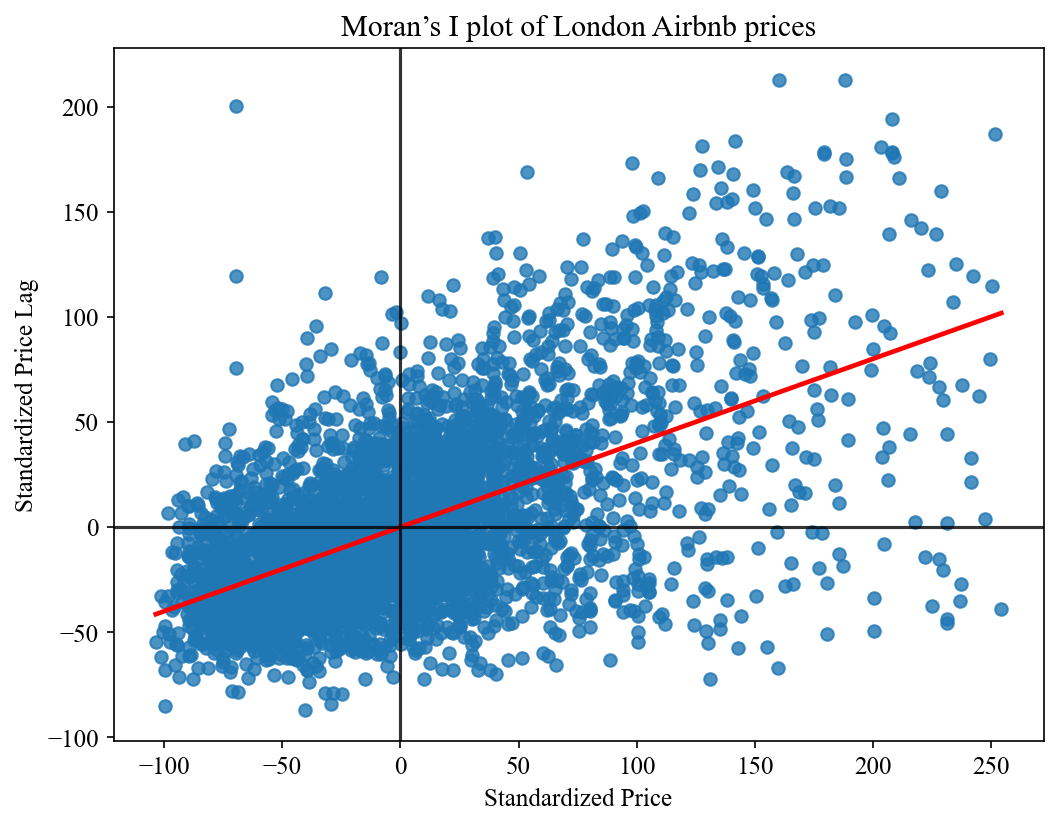

In [13]:
f, ax = plt.subplots(1, figsize=(8, 6))

sns.regplot(
    x='price_std', # variable of interest
    y='price_lag_std', # spatial lag
    ci=None, # suppress the plotting of the confidence interval
    data=LDN_Tracts_Agg_filtered, # dataset
    line_kws={'color':'r'}
)

ax.axvline(0, c='k', alpha=0.8)
ax.axhline(0, c='k', alpha=0.8)

ax.set_title('Moran’s I plot of London Airbnb prices')
ax.set_xlabel('Standardized Price')
ax.set_ylabel('Standardized Price Lag')
plt.show()

Los puntos del cuadrante superior derecho tienen una autocorrelación espacial global positiva, mientras que los puntos del cuadrante inferior izquierdo tienen una autocorrelación espacial negativa. La línea de mejor ajuste, sombreada en rojo, se superpone al gráfico para mostrar la fuerza de la relación. En este caso, la relación parece razonablemente fuerte, ya que los puntos se distribuyen por encima y por debajo de la línea de mejor ajuste aproximadamente en el mismo grado.

Morans I: 0.40013909191816205
p-value: 0.001


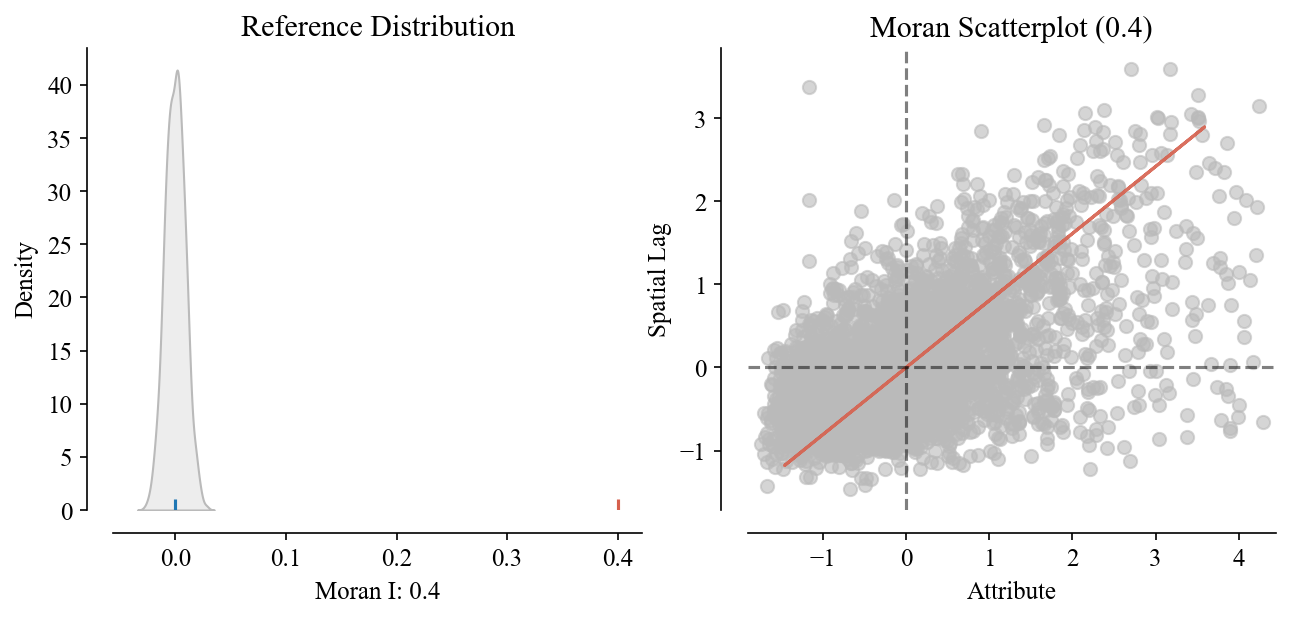

In [14]:
morans_stat = Moran(LDN_Tracts_Agg_filtered['price'], w)

print(f'Morans I: {morans_stat.I}')
print(f'p-value: {morans_stat.p_sim}')

plot_moran(morans_stat)
plt.show()

El estadístico I de Moran resultante es ~0,40, con un p-valor de 0,001. Esto indica que existe una relación espacial estadísticamente significativa en los datos de precios de los Airbnbs de Londres.

## Local spatial autocorrelation – the London Airbnb example

La autocorrelación espacial local mide la relación entre cada observación y su entorno localizado. En comparación con la autocorrelación espacial global, la autocorrelación espacial local no devuelve un único valor, sino que devuelve valores por observación.

### Local Indicators of Spatial Associations (LISAs)

Los LISA son estadísticas espaciales que se derivan de estadísticas espaciales globales y calculan patrones de conglomerados locales, también conocidos como valores atípicos espaciales.

- Los LISA de todas y cada una de las observaciones representan el grado de agrupación espacial de valores similares en la vecindad de esa observación.

- La suma de los LISA de una observación debe ser proporcional al indicador global asociado del que se derivan los LISA.

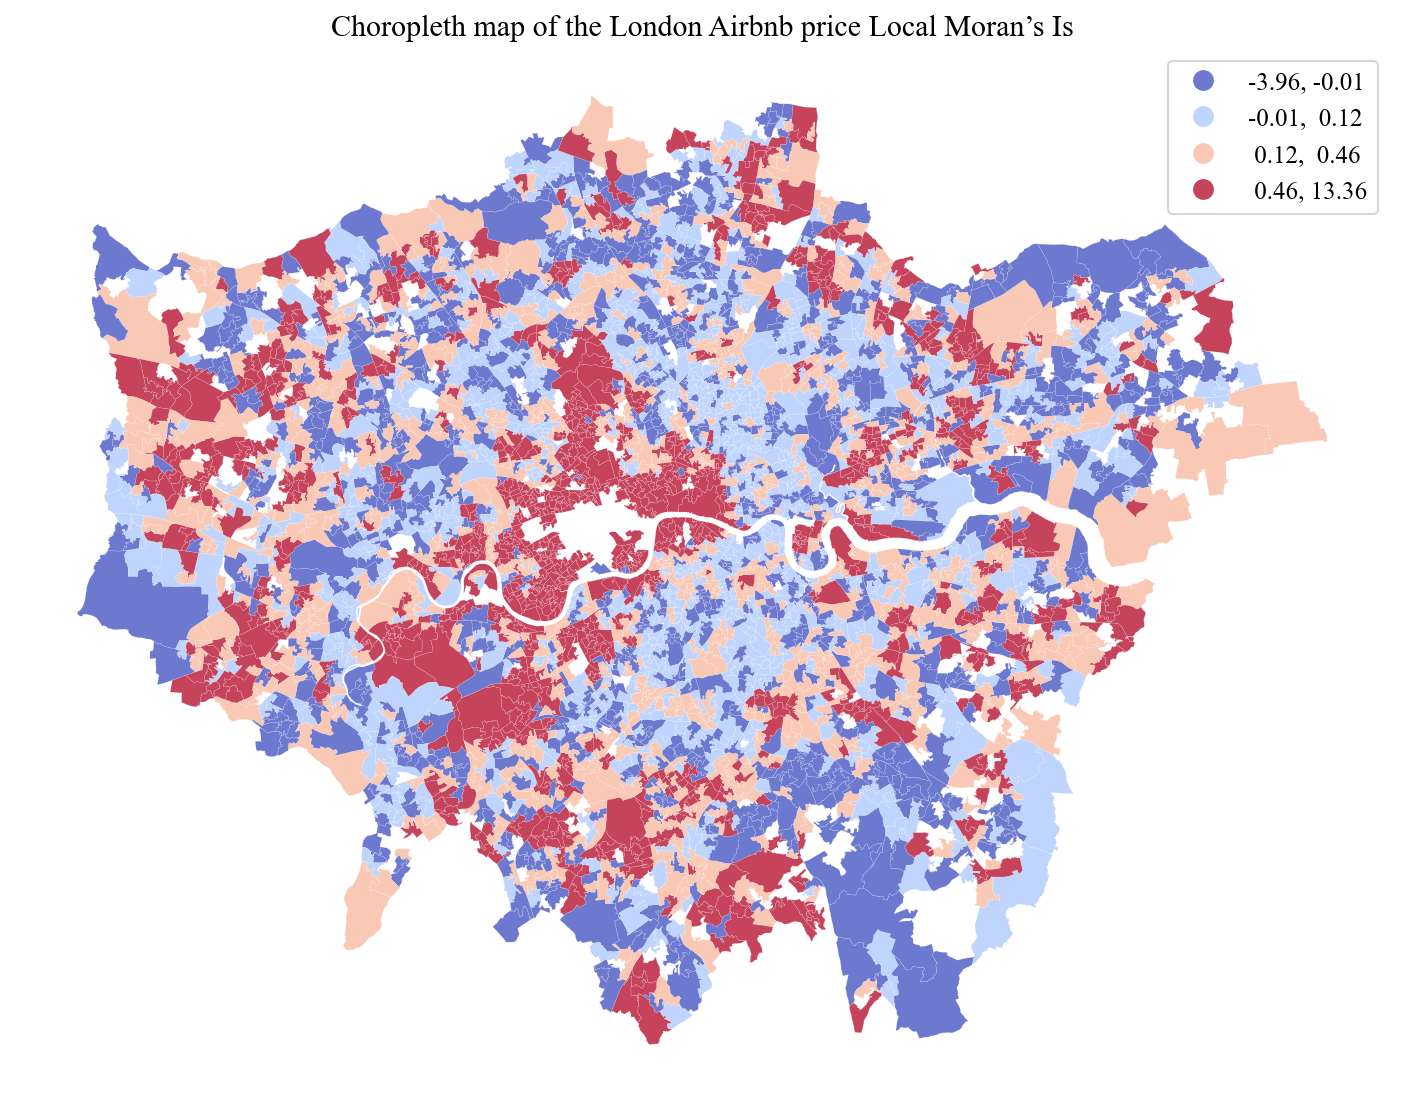

In [15]:
price_lisa = Moran_Local(LDN_Tracts_Agg_filtered['price'], w)

f, ax = plt.subplots(1, figsize=(10, 10))

# Create a new column with the values from the Moran's Local LISAs

LDN_Tracts_Agg_filtered.assign(
    ML_Is=price_lisa.Is
    
# Plot choropleth of local statistics
    
).plot(
    column='ML_Is', 
    cmap='coolwarm', 
    scheme='quantiles',
    k=4, 
    edgecolor='white', 
    linewidth=0.1, 
    alpha=0.75,
    legend=True,
    ax=ax
)

plt.title('Choropleth map of the London Airbnb price Local Moran’s Is')
plt.tight_layout()
plt.axis('off')
plt.show()

Un valor positivo de I indica que una observación tiene observaciones vecinas con valores de atributo altos o bajos similares; esta observación forma parte de un conglomerado. Un valor negativo de I indica que una observación tiene observaciones vecinas con valores distintos; esta observación es un valor atípico. En ambos casos, el p-valor de la observación debe ser lo suficientemente pequeño para que el conglomerado o el valor atípico se consideren estadísticamente significativos.

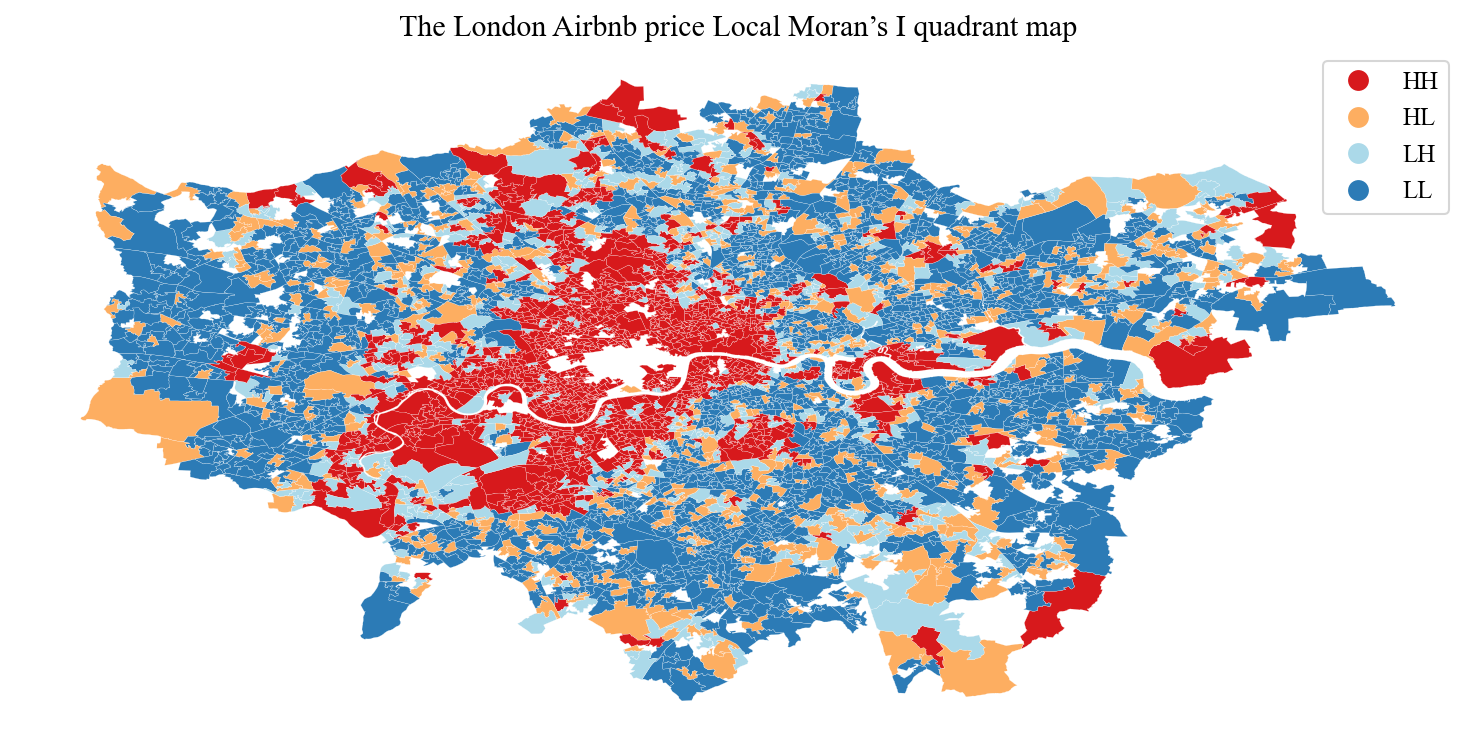

In [16]:
# Plot a map assigning each observation with its quadrant value HH, HL, LH, LL

f, ax = plt.subplots(1, figsize=(10, 10))

esdaplot.lisa_cluster(
    price_lisa,
    LDN_Tracts_Agg_filtered,
    p=1,
    ax=ax
)

plt.title('The London Airbnb price Local Moran’s I quadrant map')
plt.tight_layout()
plt.axis('off')
plt.show()

El campo "tipo de conglomerado" distingue entre un conglomerado, ignorando si es estadísticamente significativo, de valores altos (HH), un conglomerado de valores bajos (LL), un valor atípico en el que un valor alto está rodeado principalmente por valores bajos (HL) y un valor atípico en el que un valor bajo está rodeado principalmente por valores altos (LH).

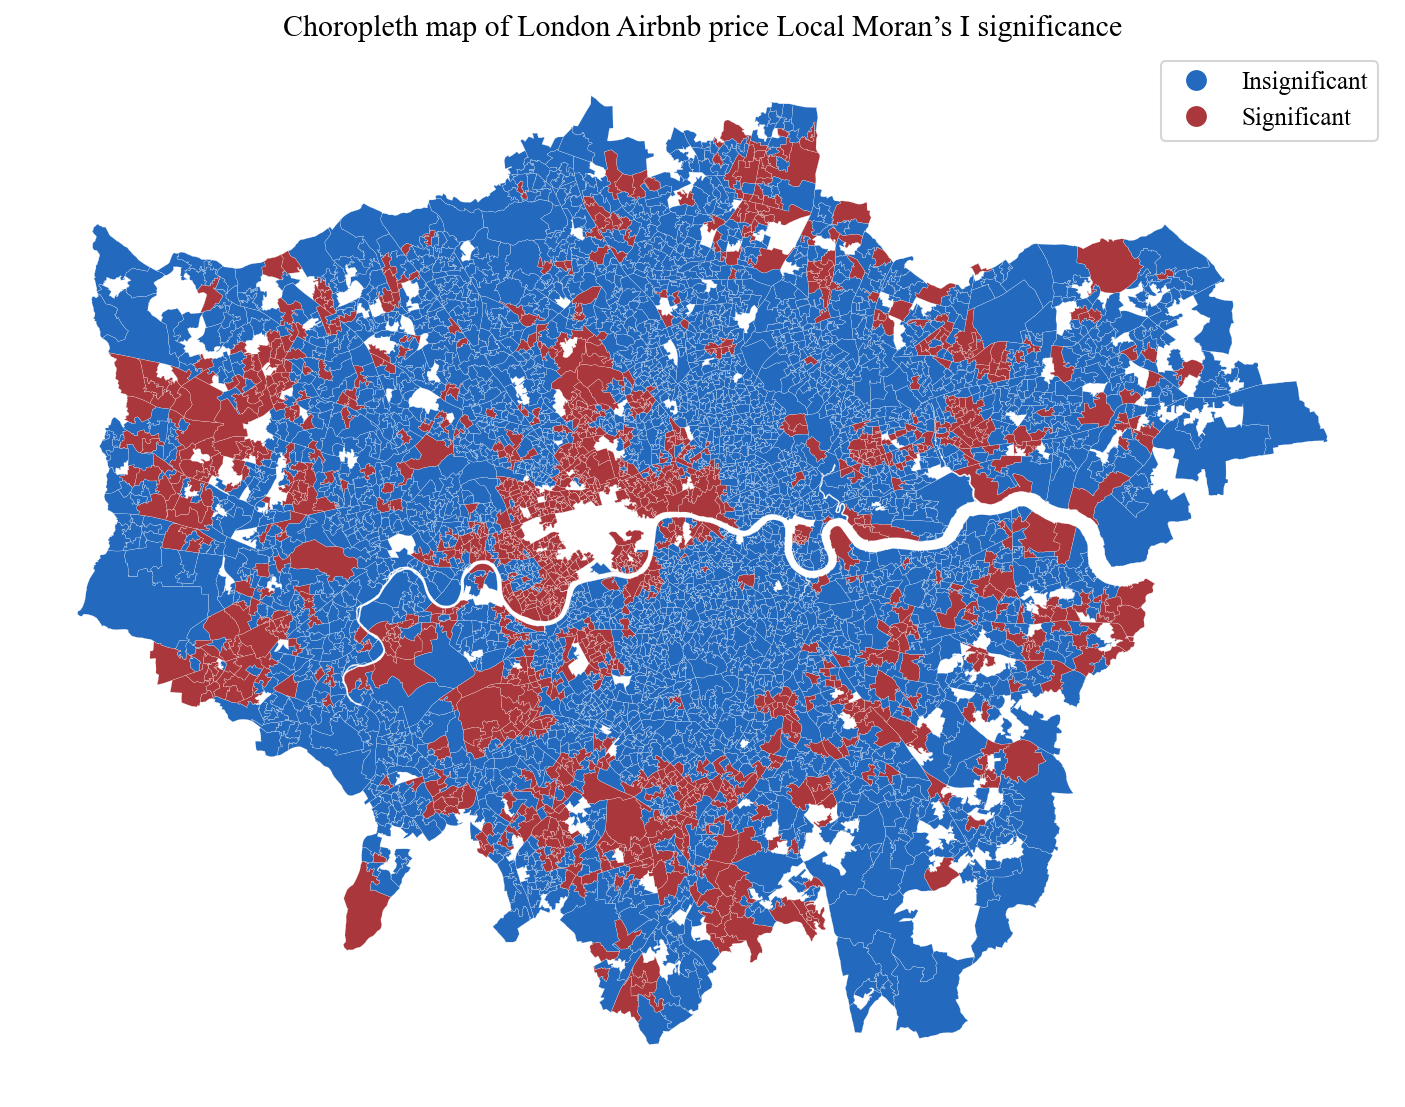

In [17]:
f, ax = plt.subplots(1, figsize=(10, 10))

# First, we need to find out which observations are significant

alpha = 0.05
labels = pd.Series(
    1 * (price_lisa.p_sim < alpha), # 1: Indicates significance at alpha of .05 and 0 indicates insignificant values
    index=LDN_Tracts_Agg_filtered.index

# Recoding 1 to be "Significant and 0 to be "Insignificant"
    
).map({1: 'Significant', 0: 'Insignificant'})

# Creating a new column with the labels for significance called ML_Sig

LDN_Tracts_Agg_filtered.assign(
    ML_Sig=labels

# Ploting a map of the insignificant values
    
).plot(
    column='ML_Sig', 
    categorical=True,
    k=2,
    cmap='vlag',
    linewidth=0.1,
    edgecolor='white',
    legend=True,
    ax=ax
)

plt.title('Choropleth map of London Airbnb price Local Moran’s I significance')
plt.tight_layout()
plt.axis('off')
plt.show()

El campo "tipo de conglomerado" distingue entre un conglomerado de valores estadísticamente significativos y no significativos.

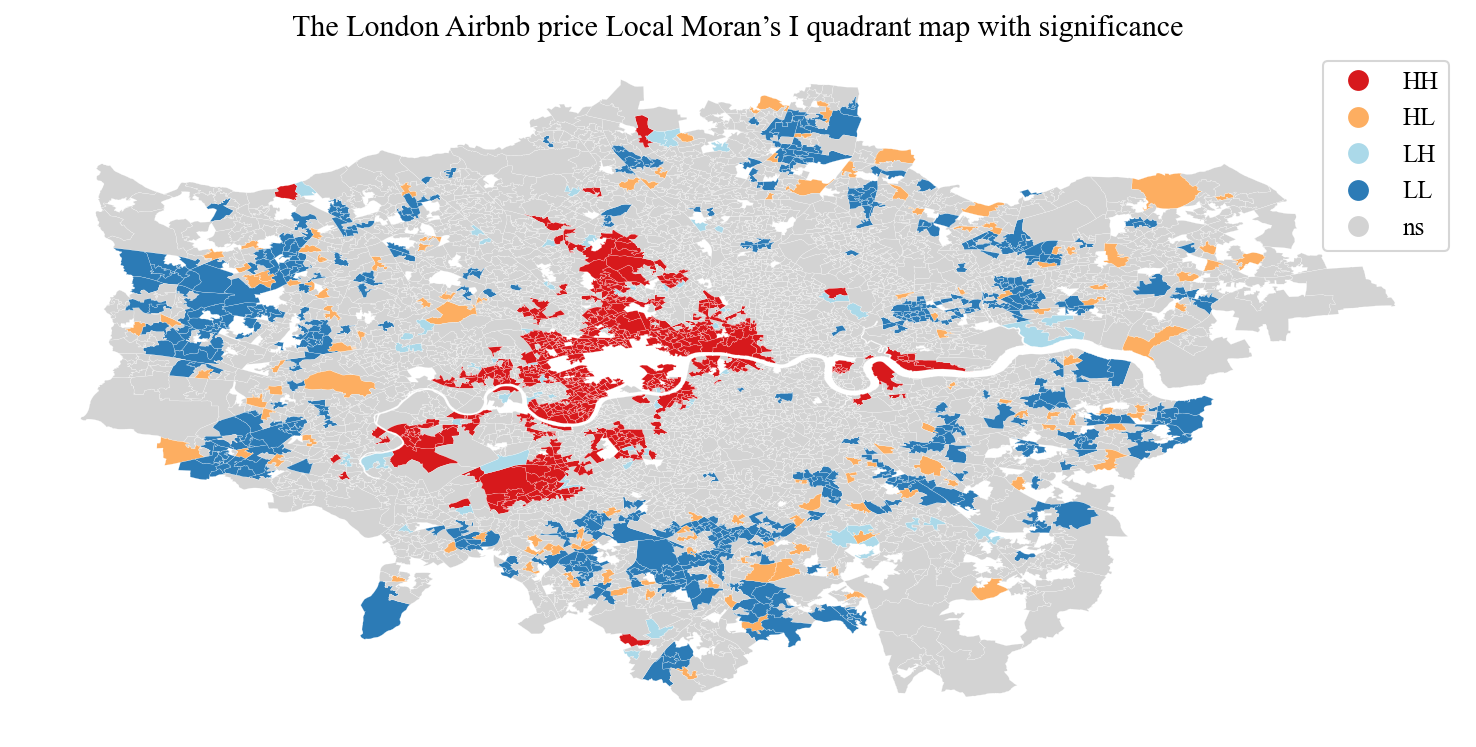

In [18]:
# Plot one final map using the alpha of 0.05

f, ax = plt.subplots(1, figsize=(10, 10))

esdaplot.lisa_cluster(
    price_lisa,
    LDN_Tracts_Agg_filtered,
    p=alpha,
    ax=ax)

plt.title('The London Airbnb price Local Moran’s I quadrant map with significance')
plt.tight_layout()
plt.axis('off')
plt.show()

El campo "tipo de conglomerado" distingue entre un conglomerado estadísticamente significativo de valores altos (HH), un conglomerado de valores bajos (LL), un valor atípico en el que un valor alto está rodeado principalmente por valores bajos (HL), un valor atípico en el que un valor bajo está rodeado principalmente por valores altos (LH) y valores no significativos.
